In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline
plt.style.use('ggplot')

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.var_model import VAR

# from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [2]:
# source https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/

In [3]:
ls data/

sales_data.csv         store_item.csv         train.csv
sample_submission.csv  test.csv


In [4]:
store_item = pd.read_csv('data/store_item.csv')

In [5]:
store_item.head()

,date,1_1,1_2,1_3,1_4,1_5,1_6,1_7,1_8,1_9,...,10_41,10_42,10_43,10_44,10_45,10_46,10_47,10_48,10_49,10_50
0,2013-01-01,13,33,15,10,11,31,25,33,18,...,12,20,24,17,45,37,11,25,17,33
1,2013-01-02,11,43,30,11,6,36,23,37,23,...,10,22,29,10,45,33,13,24,13,37
2,2013-01-03,14,23,14,8,8,18,34,38,25,...,17,27,43,20,56,28,16,29,19,46
3,2013-01-04,13,18,10,19,9,19,36,54,22,...,13,24,27,12,50,44,11,39,23,51
4,2013-01-05,10,34,23,12,8,31,38,51,29,...,14,25,31,25,62,45,16,34,22,41


In [6]:
#set datatime to index
store_item['date'] = pd.to_datetime(store_item['date'])
store_item = store_item.set_index('date')

In [7]:
store_item.head()

,1_1,1_2,1_3,1_4,1_5,1_6,1_7,1_8,1_9,1_10,...,10_41,10_42,10_43,10_44,10_45,10_46,10_47,10_48,10_49,10_50
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,13,33,15,10,11,31,25,33,18,37,...,12,20,24,17,45,37,11,25,17,33
2013-01-02,11,43,30,11,6,36,23,37,23,34,...,10,22,29,10,45,33,13,24,13,37
2013-01-03,14,23,14,8,8,18,34,38,25,32,...,17,27,43,20,56,28,16,29,19,46
2013-01-04,13,18,10,19,9,19,36,54,22,45,...,13,24,27,12,50,44,11,39,23,51
2013-01-05,10,34,23,12,8,31,38,51,29,35,...,14,25,31,25,62,45,16,34,22,41


In [8]:
#split into train and valid sets
train_original = store_item.loc['2013-01-01':'2017-09-30']
valid_original  = store_item.loc['2017-10-01':'2017-12-31']

In [9]:
train_original.shape

(1734, 500)

In [10]:
df = store_item.copy()

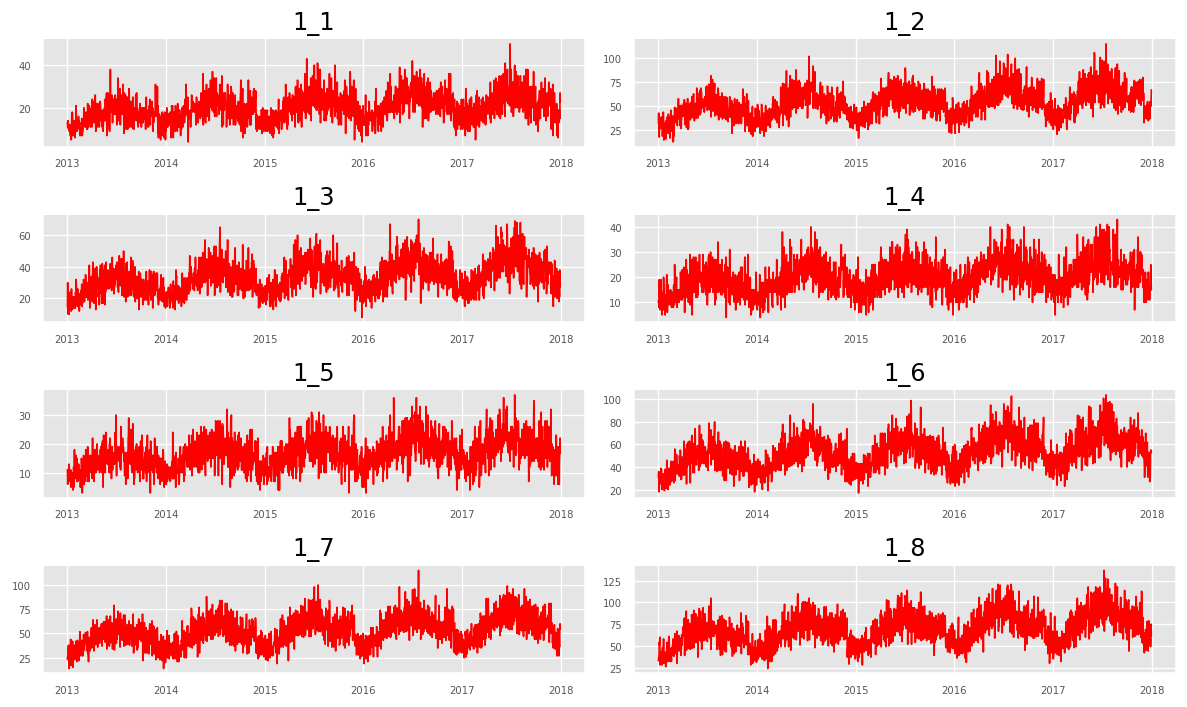

In [11]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

#### Check for Stationarity and Make the Time Series Stationary

##### ADF Test

In [12]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")  

In [13]:
sampling = random.choices(np.arange(train_original.shape[1]), k=10)
sampling 

[266, 433, 465, 33, 291, 40, 303, 103, 349, 330]

In [14]:
df_train=train_original.iloc[:,sampling]
df_train.head()

,6_17,9_34,10_16,1_34,6_42,1_41,7_4,3_4,7_50,7_31
date,,,,,,,,,,
2013-01-01,18,19,20,23,15,6,6,9,21,23
2013-01-02,20,10,18,6,21,15,8,15,30,28
2013-01-03,17,15,10,15,14,5,9,9,20,13
2013-01-04,16,14,14,13,21,9,2,16,27,23
2013-01-05,15,17,14,15,27,13,15,16,18,24


In [15]:
# ADF Test on 10 columns
df_train=train_original.iloc[:]
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "1_1" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.9366
 No. Lags Chosen       = 23
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0413. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "1_2" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.8589
 No. Lags Chosen       = 23
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0503. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "1_3" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Si

    Augmented Dickey-Fuller Test on "1_24" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.8966
 No. Lags Chosen       = 24
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0457. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "1_25" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.0695
 No. Lags Chosen       = 24
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0289. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "1_26" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level   

    Augmented Dickey-Fuller Test on "1_48" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.0455
 No. Lags Chosen       = 24
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0309. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "1_49" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.8293
 No. Lags Chosen       = 20
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0542. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "1_50" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.


    Augmented Dickey-Fuller Test on "2_19" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.6851
 No. Lags Chosen       = 20
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0767. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "2_20" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.3841
 No. Lags Chosen       = 21
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.1463. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "2_21" 
    -----------------------------------------------
 Null Hypothesis: Data has unit 

    Augmented Dickey-Fuller Test on "2_43" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.79
 No. Lags Chosen       = 24
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0597. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "2_44" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.82
 No. Lags Chosen       = 21
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0555. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "2_45" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root

    Augmented Dickey-Fuller Test on "3_13" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.8688
 No. Lags Chosen       = 24
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0491. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "3_14" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.6118
 No. Lags Chosen       = 22
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0906. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "3_15" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.


    Augmented Dickey-Fuller Test on "3_33" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.7743
 No. Lags Chosen       = 24
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.062. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "3_34" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.7488
 No. Lags Chosen       = 20
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.066. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "3_35" 
    -----------------------------------------------
 Null Hypothesis: Data has unit ro

    Augmented Dickey-Fuller Test on "4_3" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.071
 No. Lags Chosen       = 25
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0288. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "4_4" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.0189
 No. Lags Chosen       = 23
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0332. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "4_5" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0

    Augmented Dickey-Fuller Test on "4_27" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.0026
 No. Lags Chosen       = 20
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0347. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "4_28" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.9291
 No. Lags Chosen       = 23
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0421. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "4_29" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level   

    Augmented Dickey-Fuller Test on "4_47" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.0674
 No. Lags Chosen       = 23
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0291. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "4_48" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.6075
 No. Lags Chosen       = 24
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0914. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "4_49" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.


    Augmented Dickey-Fuller Test on "5_17" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.7243
 No. Lags Chosen       = 20
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0699. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "5_18" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.6936
 No. Lags Chosen       = 22
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0752. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "5_19" 
    -----------------------------------------------
 Null Hypothesis: Data has unit 

    Augmented Dickey-Fuller Test on "5_37" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.7148
 No. Lags Chosen       = 20
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0715. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "5_38" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.0075
 No. Lags Chosen       = 23
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0342. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "5_39" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.


    Augmented Dickey-Fuller Test on "6_7" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.9207
 No. Lags Chosen       = 25
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.043. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "6_8" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.8476
 No. Lags Chosen       = 25
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0518. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "6_9" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Sig

    Augmented Dickey-Fuller Test on "6_29" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.7837
 No. Lags Chosen       = 25
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0606. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "6_30" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.7331
 No. Lags Chosen       = 20
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0685. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "6_31" 
    -----------------------------------------------
 Null Hypothesis: Data has unit 

    Augmented Dickey-Fuller Test on "6_50" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.6328
 No. Lags Chosen       = 21
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0864. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "7_1" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.2821
 No. Lags Chosen       = 20
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0157. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "7_2" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 S

    Augmented Dickey-Fuller Test on "7_20" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.0679
 No. Lags Chosen       = 24
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.029. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "7_21" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.9599
 No. Lags Chosen       = 22
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0388. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "7_22" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    

    Augmented Dickey-Fuller Test on "7_44" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.7897
 No. Lags Chosen       = 20
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0598. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "7_45" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.6262
 No. Lags Chosen       = 25
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0877. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "7_46" 
    -----------------------------------------------
 Null Hypothesis: Data has unit 

    Augmented Dickey-Fuller Test on "8_14" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.8517
 No. Lags Chosen       = 23
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0513. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "8_15" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.9203
 No. Lags Chosen       = 23
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.043. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "8_16" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 

    Augmented Dickey-Fuller Test on "8_34" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.0455
 No. Lags Chosen       = 24
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0309. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "8_35" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.8508
 No. Lags Chosen       = 23
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0514. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "8_36" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.


    Augmented Dickey-Fuller Test on "9_7" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.8111
 No. Lags Chosen       = 24
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0567. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "9_8" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.8677
 No. Lags Chosen       = 25
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0492. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "9_9" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Si

    Augmented Dickey-Fuller Test on "9_31" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.019
 No. Lags Chosen       = 24
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0332. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "9_32" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.8274
 No. Lags Chosen       = 23
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0545. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "9_33" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 

    Augmented Dickey-Fuller Test on "10_5" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.3822
 No. Lags Chosen       = 24
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0116. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "10_6" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.8297
 No. Lags Chosen       = 23
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0542. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "10_7" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.


    Augmented Dickey-Fuller Test on "10_27" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.8846
 No. Lags Chosen       = 21
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0472. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "10_28" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.7933
 No. Lags Chosen       = 24
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0592. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "10_29" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationar

    Augmented Dickey-Fuller Test on "10_47" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.707
 No. Lags Chosen       = 20
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0728. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "10_48" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.1193
 No. Lags Chosen       = 25
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0252. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "10_49" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary

In [16]:
# 1st difference
differenced = train_original.diff().dropna()

In [17]:
differenced

,1_1,1_2,1_3,1_4,1_5,1_6,1_7,1_8,1_9,1_10,...,10_41,10_42,10_43,10_44,10_45,10_46,10_47,10_48,10_49,10_50
date,,,,,,,,,,,,,,,,,,,,,
2013-01-02,-2.0,10.0,15.0,1.0,-5.0,5.0,-2.0,4.0,5.0,-3.0,...,-2.0,2.0,5.0,-7.0,0.0,-4.0,2.0,-1.0,-4.0,4.0
2013-01-03,3.0,-20.0,-16.0,-3.0,2.0,-18.0,11.0,1.0,2.0,-2.0,...,7.0,5.0,14.0,10.0,11.0,-5.0,3.0,5.0,6.0,9.0
2013-01-04,-1.0,-5.0,-4.0,11.0,1.0,1.0,2.0,16.0,-3.0,13.0,...,-4.0,-3.0,-16.0,-8.0,-6.0,16.0,-5.0,10.0,4.0,5.0
2013-01-05,-3.0,16.0,13.0,-7.0,-1.0,12.0,2.0,-3.0,7.0,-10.0,...,1.0,1.0,4.0,13.0,12.0,1.0,5.0,-5.0,-1.0,-10.0
2013-01-06,2.0,4.0,0.0,4.0,5.0,0.0,-6.0,9.0,6.0,19.0,...,-3.0,7.0,5.0,-6.0,2.0,5.0,1.0,13.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-09-26,4.0,12.0,12.0,0.0,1.0,4.0,-4.0,16.0,-2.0,22.0,...,-2.0,17.0,19.0,1.0,23.0,2.0,-2.0,16.0,-1.0,16.0
2017-09-27,9.0,-4.0,3.0,8.0,4.0,1.0,-1.0,-1.0,10.0,-12.0,...,1.0,-10.0,10.0,2.0,-6.0,11.0,7.0,-15.0,1.0,1.0
2017-09-28,-4.0,-2.0,-4.0,-10.0,2.0,-5.0,26.0,-22.0,-1.0,-2.0,...,13.0,13.0,2.0,1.0,4.0,-8.0,-7.0,9.0,0.0,2.0


#### Re-run ADF test on each differenced series.

In [18]:
df_differenced=differenced.iloc[:,sampling]

In [19]:
# ADF Test on each column of 1st Differences Dataframe

for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "6_17" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -16.2317
 No. Lags Chosen       = 19
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "9_34" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -11.9533
 No. Lags Chosen       = 22
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "10_16" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 

### Multivariate Forecast Model
#### Vector Autoregression (VAR)

In [21]:
# choice lag = 10

In [73]:
model_fitted = model.fit(20)

In [74]:
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

20


In [75]:
# Input data for forecasting
forecast_input = differenced.values[-lag_order:]
forecast_input

array([[-14., -20.,  -7., ..., -37.,  -8., -22.],
       [  4.,  14.,   1., ...,   6.,  -2.,  -4.],
       [ -7.,  -1.,   4., ...,   1.,   2.,  14.],
       ...,
       [ -4.,  -2.,  -4., ...,   9.,   0.,   2.],
       [  5.,  11.,  -2., ...,   5.,  -4.,   8.],
       [  2.,  13.,  13., ...,  -1.,  -2.,  13.]])

In [77]:
forecast_input.shape

(20, 500)

In [76]:
valid_original.shape

(92, 500)

In [78]:
fc = model_fitted.forecast(y=forecast_input, steps=20)
fc.shape

(20, 500)

In [79]:
df_forecast = pd.DataFrame(fc, index=valid_original.index[:lag_order], columns=df.columns + '_2d')
df_forecast

,1_1_2d,1_2_2d,1_3_2d,1_4_2d,1_5_2d,1_6_2d,1_7_2d,1_8_2d,1_9_2d,1_10_2d,...,10_41_2d,10_42_2d,10_43_2d,10_44_2d,10_45_2d,10_46_2d,10_47_2d,10_48_2d,10_49_2d,10_50_2d
date,,,,,,,,,,,,,,,,,,,,,
2017-10-01,1.165239,-3.653102,-1.202709,10.262945,7.333536,8.539675,-14.094307,9.182592,3.796441,11.128965,...,1.302852,20.397973,6.105837,1.690195,11.714607,3.083770,-0.207806,12.581980,15.431033,7.053194
2017-10-02,-12.913948,-26.853579,-15.617291,-8.807685,-14.092541,-30.180646,-18.537312,-36.949544,-21.945664,-19.459924,...,-16.927923,-24.029603,-28.206609,-15.400374,-28.807857,-38.565211,-15.542818,-27.893727,-16.408037,-45.652862
2017-10-03,2.160344,9.781373,-0.558104,-3.747657,2.792420,13.059933,17.184975,13.534336,0.586050,6.060522,...,8.800441,5.685440,8.288925,1.767356,5.750469,8.831076,6.250486,2.646583,7.002143,5.384664
2017-10-04,5.086262,-4.985282,8.397765,3.747128,6.028732,1.476935,-5.886754,-1.663128,-0.406534,-0.743650,...,4.530895,0.014633,9.948521,7.300488,-7.881548,6.071104,1.664020,7.629306,3.576253,4.210341
2017-10-05,-0.537714,15.392710,2.477117,-4.231230,-2.991020,7.829128,-6.161637,4.106379,11.938808,7.421638,...,1.421368,6.588205,11.100941,-1.533169,30.411321,1.423215,5.268598,8.344780,-4.816318,16.516480
2017-10-06,-1.395734,2.144552,-2.400834,1.745125,2.591328,5.854658,14.665160,6.007012,2.515681,-8.474552,...,-0.604940,-1.563910,-10.008960,13.033431,-10.098543,4.657911,-0.467178,-3.907737,5.146416,-1.204659
2017-10-07,5.327111,-1.352123,-2.097309,3.993027,-1.379962,-1.690359,-7.098818,1.642154,5.792252,13.006965,...,-3.118399,2.335850,-0.811202,-8.925400,-0.669255,3.693913,-1.466844,1.581333,6.083636,3.702442
2017-10-08,1.089727,2.373648,14.450081,2.120213,2.861931,-3.713826,5.509122,14.296086,-6.839707,-2.581655,...,1.953016,14.620109,4.310313,2.451685,9.182262,4.067945,9.528066,1.334314,1.850021,4.721678
2017-10-09,-7.731779,-18.585946,-19.177633,-6.793914,-2.494310,-17.032085,-11.174939,-37.456586,-6.928873,-23.059516,...,-10.214929,-26.085201,-21.514023,-13.849757,-42.532355,-21.898883,-16.222288,-21.510173,-17.022848,-31.453691


#### Invert the transformation to get the real forecast

In [80]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [81]:
df_results = invert_transformation(train_original, df_forecast, second_diff=True)        


In [82]:
df_results.shape

(20, 1500)

In [83]:
random.choices(np.arange(train_original.shape[1]))

[1]

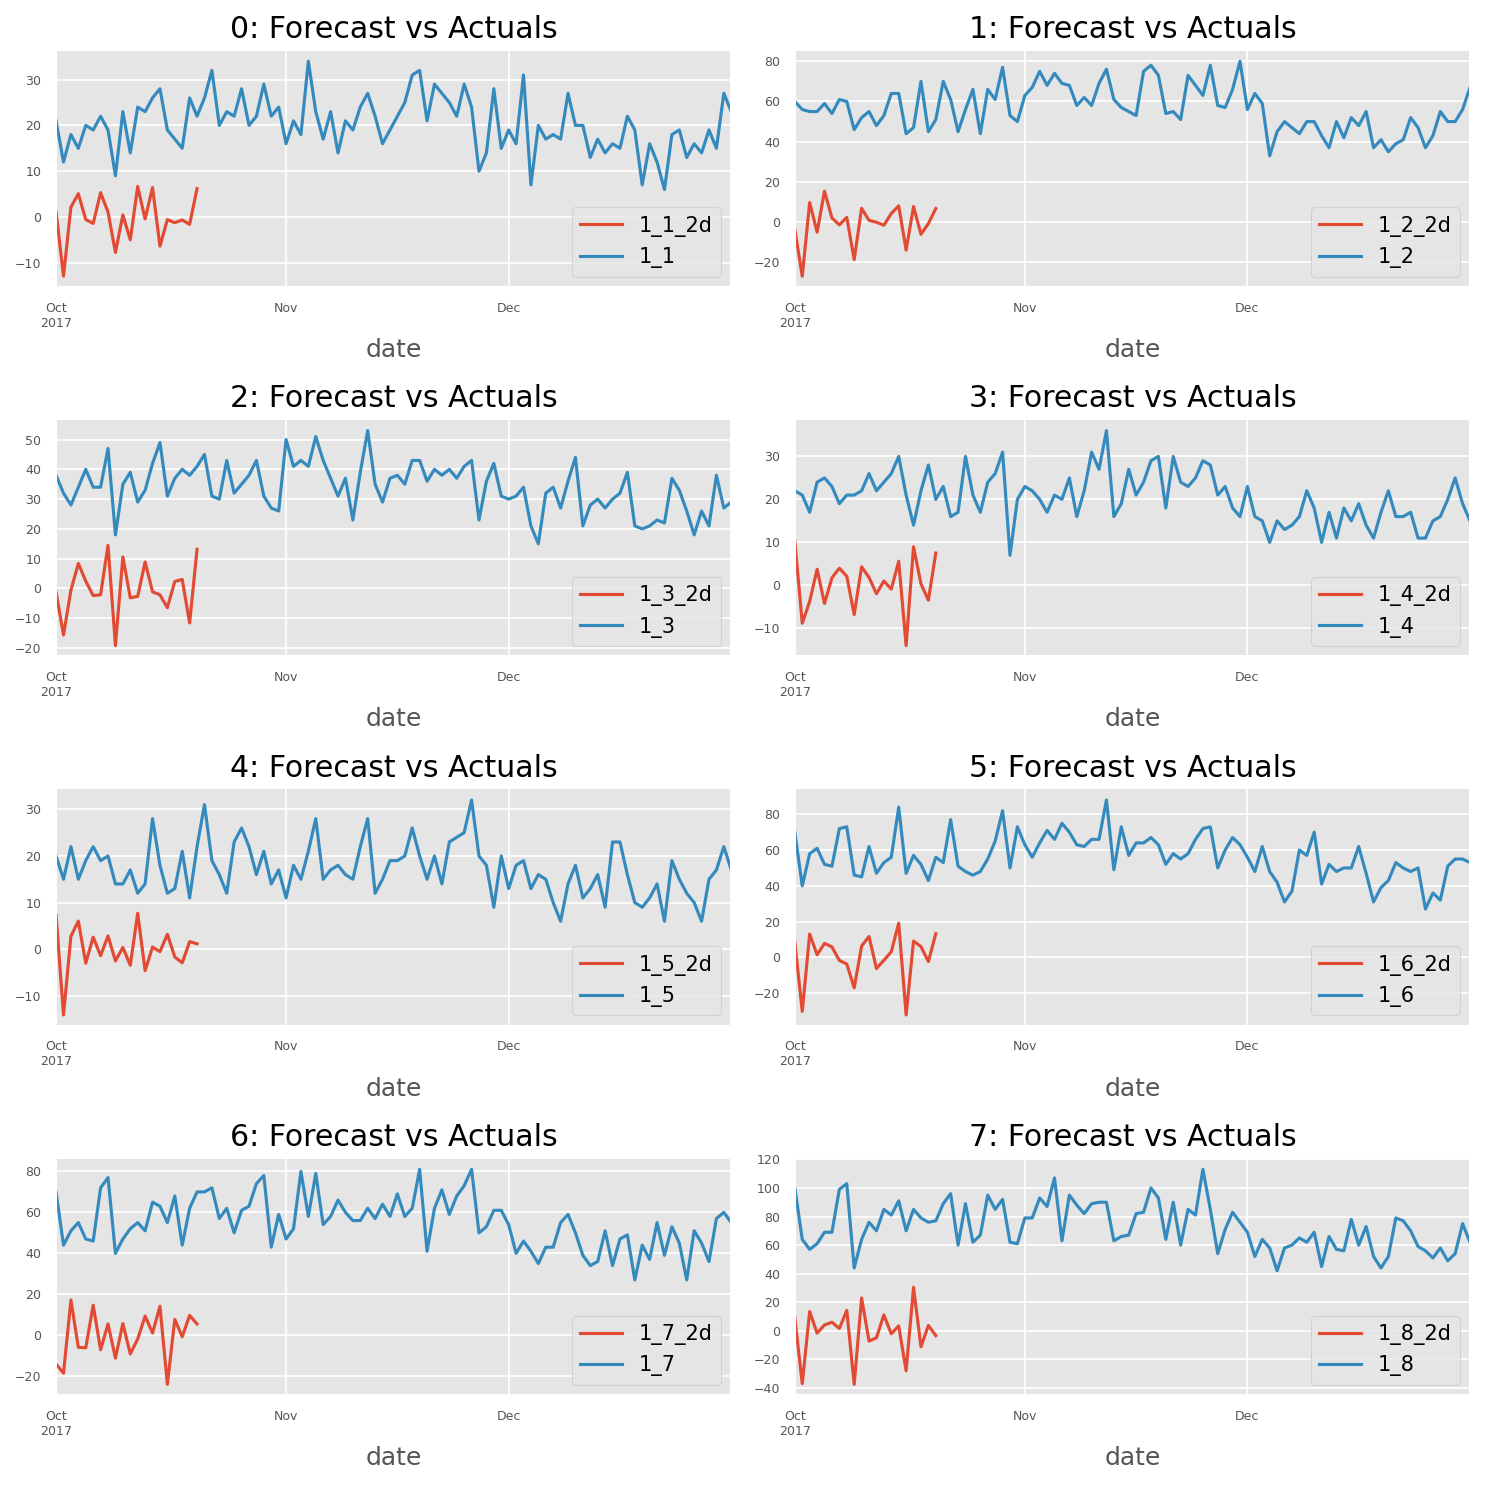

In [84]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=150, figsize=(10,10))
for i, ax in enumerate( axes.flatten()):
#     col = random.choices(np.arange(train_original.shape[1]))
    col =i
    df_results[df_results.columns[col]].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    valid_original[valid_original.columns[col]].plot(legend=True, ax=ax);
    ax.set_title( f'{col}: Forecast vs Actuals')
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();